# Modeling

In this notebook, we will focus entirely on the 3D OCT volumes and leave the merged 2D image set for potential analysis in the future.  The objectives here will be first an attempt to replicate the building and training of the CNN built by the original authors of the dataset, and then to test out two different alternative architectures.

## Import Statements

In [1]:
# Custom Modules Import
import os,sys
sys.path.append(os.path.abspath('..'))
from octcv.arrViz import *
from octcv.mdl_lib import *

# Silence Benign Warnings
os.environ["KERAS_BACKEND"] = "tensorflow"     # stop Keras from probing other backends
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"       # 0=all, 1=INFO off, 2=+WARNING off, 3=+ERROR off
# Optional: disable oneDNN optimized kernels if you want bit-for-bit stability on CPU
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# General
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as iPyDisplay, Markdown as iPyMD

# Additional Pre-Processing
from sklearn.model_selection import train_test_split

# Modeling (Tensorflow/Keras)
from visualkeras import layered_view
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import Conv3D,Conv2D,Dense,MaxPool2D,MaxPool3D,Flatten,Dropout,\
BatchNormalization,GlobalAveragePooling3D,GlobalAveragePooling2D,ReLU,Input,Add
from keras.metrics import AUC
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Model as kerasModel
from keras import ops as Kops

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve

2025-11-17 10:33:25.608103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 10:33:25.617813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763393605.627167  180994 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763393605.630325  180994 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763393605.638293  180994 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Loading Datasets

For the case of a unimodal CNN, the entirety of X will be the image data - however, to conserve RAM, will keep as filepaths for now and define a custom function to load the arrays for a given set during training -- this is done via a custom method `octcv.mdl_lib.xY_split()` which returns a `y_label`, `y`, and `X` in which `X` is an instance of the `XVolSet` class, meaning it stores the filepaths and the actual image arrays can be loaded simply via calling the `.load()` method of a given instance -- see help() or source code under `../octcv/mdl_lib.py` for more information.

In [2]:
#++++LOAD+DATA++++#
v_test = pd.read_csv('./volumes_TEST.csv')
v_train = pd.read_csv('./volumes_train.csv')

In [3]:
print(v_test.info())
print('-'*50)
print(v_test.describe())
v_test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dx_class          222 non-null    object
 1   glaucoma          222 non-null    int64 
 2   PIN               222 non-null    int64 
 3   laterality        222 non-null    object
 4   left_eye          222 non-null    int64 
 5   set               222 non-null    int64 
 6   normalized_array  222 non-null    object
 7   display_volume    222 non-null    object
dtypes: int64(4), object(4)
memory usage: 14.0+ KB
None
--------------------------------------------------
         glaucoma         PIN    left_eye    set
count  222.000000  222.000000  222.000000  222.0
mean     0.729730  296.355856    0.481982    1.0
std      0.445103  178.763917    0.500804    0.0
min      0.000000    3.000000    0.000000    1.0
25%      0.000000  152.250000    0.000000    1.0
50%      1.000000  292.500000    0.

,dx_class,glaucoma,PIN,laterality,left_eye,set,normalized_array,display_volume
0,glaucoma,1,498,OS,1,1,../datasrc/volumesOCT/normalized/p498_Glaucoma...,../datasrc/volumesOCT/POAG-002774-2008-02-19-O...
1,glaucoma,1,190,OD,0,1,../datasrc/volumesOCT/normalized/p190_Glaucoma...,../datasrc/volumesOCT/POAG-001086-2008-08-04-O...
2,glaucoma,1,32,OD,0,1,../datasrc/volumesOCT/normalized/p032_Glaucoma...,../datasrc/volumesOCT/POAG-000267-2008-07-28-O...


In [4]:
print(v_train.info())
print('-'*50)
print(v_train.describe())
v_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dx_class          888 non-null    object
 1   glaucoma          888 non-null    int64 
 2   PIN               888 non-null    int64 
 3   laterality        888 non-null    object
 4   left_eye          888 non-null    int64 
 5   set               888 non-null    int64 
 6   normalized_array  888 non-null    object
 7   display_volume    888 non-null    object
dtypes: int64(4), object(4)
memory usage: 55.6+ KB
None
--------------------------------------------------
         glaucoma         PIN    left_eye    set
count  888.000000  888.000000  888.000000  888.0
mean     0.771396  315.075450    0.500000    1.0
std      0.420170  182.347698    0.500282    0.0
min      0.000000    1.000000    0.000000    1.0
25%      1.000000  155.000000    0.000000    1.0
50%      1.000000  319.000000    0.

,dx_class,glaucoma,PIN,laterality,left_eye,set,normalized_array,display_volume
0,glaucoma,1,347,OS,1,1,../datasrc/volumesOCT/normalized/p347_Glaucoma...,../datasrc/volumesOCT/POAG-001887-2008-01-31-O...
1,normal,0,560,OD,0,1,../datasrc/volumesOCT/normalized/p560_Normal_O...,../datasrc/volumesOCT/Normal-003164-2012-03-06...
2,glaucoma,1,398,OD,0,1,../datasrc/volumesOCT/normalized/p398_Glaucoma...,../datasrc/volumesOCT/POAG-002184-2011-06-14-O...


### Balancing Class Distributions 

As noted in earlier steps of this project (EDA) and seen in the summary outputs above, the class distribution is skewed, with glaucoma +ive data points over-represented compared to what one might find in the true population.  Nevertheless, the original authors of the dataset reported training on this dataset without any attempts to create a more representative dataset or at least balance it.  That said, for the sake of a CNN with the sole purpose of detecting the presence or absence of glaucoma based on ONH-centered OCT volumes, the model may prove to be quite useless if trained on data more representative of the true population, as its prevlance in the general population is technically a small minority ( 0.57% - 1.62% per [JAMA](https://jamanetwork.com/journals/jamaophthalmology/fullarticle/2824476) ).  As a result, it may be more important for the model to be fed a large amount of data that conveys the unique visual nuances of scans depicting eyes with glaucoma.  

Given this discrepancy, a separate dataset with more balanced classes will be generated here by cutting out some excess Glaucoma +ive data points (so that the amount in this class matches the negative class), and each model will be trained on two separate instances using the respective two datasets.

In [5]:
def balance_dataset(df,class_column='dx_class', report=False,random_seed=None):

    # Divide dataset based on unique classes
    unique_classes = df[class_column].unique()
    a,b = unique_classes
    adf = df[ df[class_column] == a ]
    bdf = df[ df[class_column] == b ]

    # Determine which one has more
    if len(adf) > len(bdf):
        large_subdf = pd.DataFrame(adf)
        small_subdf = pd.DataFrame(bdf)
    elif len(bdf) > len(adf):
        large_subdf = pd.DataFrame(bdf)
        small_subdf = pd.DataFrame(adf)

    # Randomly sample from large subdataframe the same number of rows in the small subdataframe
    if random_seed:
        np.random.seed(random_seed)
    indices = set()
    while len(indices) < len(small_subdf):
    	indices.update([np.random.choice(large_subdf.index)])
    indices = np.array(list(indices))
    large_subdf = large_subdf.reset_index()
    reduced_subdf = large_subdf[large_subdf['index']\
        .isin(indices)]\
        .drop('index',axis=1)

    # Combine the reduced large subdf back with the small df to create a balanced df
    balanced_df = pd.concat([small_subdf,reduced_subdf],axis=0)

    # Summary Report
    if report:
        print(f"Shape Change: {df.shape} --> {balanced_df.shape}")
        print('='*40)
        print(f"Original Class Distribution:\n{df.value_counts(class_column)}")
        print('-'*40)
        print(f"Balanced Class Distribution:\n{balanced_df.value_counts(class_column)}")
        print('_'*40,'\n')
    return balanced_df

print(f"\033[1;4;32m___TEST_SET___\033[0m RE-BALANCING")
vTestBalanced = balance_dataset(v_test,report=True,random_seed=42)
print(f"\033[1;4;31m___TRAINING_SET___\033[0m RE-BALANCING")
vTrainBalanced = balance_dataset(v_train,report=True,random_seed=42)

___TEST_SET___ RE-BALANCING
Shape Change: (222, 8) --> (120, 8)
Original Class Distribution:
dx_class
glaucoma    162
normal       60
Name: count, dtype: int64
----------------------------------------
Balanced Class Distribution:
dx_class
glaucoma    60
normal      60
Name: count, dtype: int64
________________________________________ 

___TRAINING_SET___ RE-BALANCING
Shape Change: (888, 8) --> (406, 8)
Original Class Distribution:
dx_class
glaucoma    685
normal      203
Name: count, dtype: int64
----------------------------------------
Balanced Class Distribution:
dx_class
glaucoma    203
normal      203
Name: count, dtype: int64
________________________________________ 



### Validation-Evaluation Split

As mentioned in the [original paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126), the dataset was divided into three different sets, with roughly

+ 80% training
+ 10% validation
+ 10% testing

Currently for this project, the data are divided into

+ 80% training
+ 20% testing

To rectify this, we will simply split our current "test set" of 222 datapoints in half -- i.e., two sets of 111 entries.  To distinguish from the original "test set", we will name them **validation** (`v_valid`) and **evaluation** (`v_eval`), where the validation set will be used in addition to the training set during model training, while the evaluation set will be used to assess model performance after training.

In [6]:
v_valid,v_eval = train_test_split(v_test,test_size=0.5,random_state=42)
print(v_valid.shape,v_eval.shape)

(111, 8) (111, 8)


In [7]:
vValidBalanced, vEvalBalanced = train_test_split(vTestBalanced, test_size=0.5,random_state=42)
print(vValidBalanced.shape,vEvalBalanced.shape)

(60, 8) (60, 8)


### y-X Split

In [8]:
# Split training, validation, and evaluation sets into y and X
vy_eval_labels, vy_eval, vX_eval = yX_split(v_eval)
vy_valid_labels, vy_valid, vX_valid = yX_split(v_valid)
vy_train_labels, vy_train, vX_train = yX_split(v_train)
print(f"\nSplit Dataset Shapes: ORIGINAL SET")
print(f"\tTrain Set(y,X): {vy_train.shape,vX_train.shape}")
print(f"\tValidation Set(y,X): {vy_valid.shape,vX_valid.shape}")
print(f"\tEvaluation Set(y,X): {vy_eval.shape,vX_eval.shape}")
print()


Split Dataset Shapes: ORIGINAL SET
	Train Set(y,X): ((888, 1), (888, 2))
	Validation Set(y,X): ((111, 1), (111, 2))
	Evaluation Set(y,X): ((111, 1), (111, 2))



In [9]:
# Same for balanced dataset
yEvalB_labels, yEvalB, XEvalB = yX_split(vEvalBalanced)
yValidB_labels, yValidB, XValidB = yX_split(vValidBalanced)
yTrainB_labels, yTrainB, XTrainB = yX_split(vTrainBalanced)
print(f"\nSplit Data Shapes: BALANCED SET")
print(f"\tTrain Set(y,X): {yTrainB.shape,XTrainB.shape}")
print(f"\tValidation Set(y,X): {yValidB.shape,XValidB.shape}")
print(f"\tEvaluation Set(y,X): {yEvalB.shape,XEvalB.shape}")
print()


Split Data Shapes: BALANCED SET
	Train Set(y,X): ((406, 1), (406, 2))
	Validation Set(y,X): ((60, 1), (60, 2))
	Evaluation Set(y,X): ((60, 1), (60, 2))



The resulting shapes for the X and y data points are each:

In [10]:
X_example = vX_train[0].load()
y_example = vy_train[0]
print(f"y_0 is a {y_example.ndim}-dimensional array\
 containing {y_example.size:,.0f} values, with shape {y_example.shape}")
print(f"X_0 is a {X_example.ndim}-dimensional array\
 containing {X_example.size:,.0f} values, with shape {X_example.shape}")

y_0 is a 1-dimensional array containing 1 values, with shape (1,)
X_0 is a 5-dimensional array containing 524,288 values, with shape (1, 64, 128, 64, 1)


As we are using sigmoid activation in the final dense layer (*see notes regarding MODEL 1 in the upcoming sections for more on the choice of the sigmoid activation function over softmax*), y should be only a single value for binary classification (either 0 or 1).

## Architectures

Here, we define three different model architectures using the functional API in Keras/TensorFlow.

+ **MODEL 1 :**  *An attempt at replicating the original model, as described in the original paper.*

    + Defined within `buildSequential()`

---

+ **MODEL 2 :**  *A ResNet like architecture, building upon some of the basic elements of Model 1, but with the introduction of a **residual block**.*

    + Defined within `buildResNet()`

---

+ **MODEL 3 :**  *An attention-based architecture, building upon the previous two models, that utilizes both **squeeze-excitation** and **spatial-attention** blocks.*

    + Defined within `buildAttnNN()`


### MODEL 1: Replicating Prior Model

As discussed previously, the initial step will be an attempt to replicate the results found in the [publication](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126) pertaining to SET 1 (the ONH-centered OCT volumes).

<div style="text-align: center;">
  <div style="display: inline-block; text-align: left;">
    <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126">
      Figure 1
    </a>
    <b>: The Original 3D CNN Architecture </b>
    <br>
    <img src="fig1.png"
      alt="isolated"
      width="720"
      style="vertical-align:middle;">
  </div>
</div>

As depicted in their diagram above and described in the paper:

>"The network is composed of **five** 3D-convolutional layers with **ReLU** activation, **batch-normalization**, **filter banks** of sizes <mark>32-32-32-32-32</mark>, **filters** of sizes <mark>7-5-3-3-3</mark> and **strides** <mark>2-1-1-1-1</mark>.  After the last convolutional layer **Global Average Pooling (GAP)** is employed and a **dense layer** to the final *softmax* output layer is added to enable the prediction of class labels and the computation of CAMs."


Since this is technically a binary classification problem and not a multiple-class classification (e.g., classifying written digits from 0-9), it is generally more common to use a **sigmoid** activation function for the final dense layer rather than a **softmax**.  In keeping with this, the **sigmoid** function will be used in this notebook for the sake of convention, although the performance will unlikely be much different.

In [11]:
# MODEL 1 : ORIGINAL SEQUENTIAL
def buildSequential(input_shape=(64,128,64,1),
                    activation='sigmoid',
                    n_classes=1,
                    model_name='original'):
    
    if activation == 'sigmoid':
        n_classes = 1

    def conv3D_block(n_channels, kernel_size,strides=1, padding='same', layer_name=None):
        if layer_name: 
            cname = f"BLOCK{layer_name}_Conv3D"
            bname = f"BLOCK{layer_name}_BatchNorm"
            rname = f"BLOCK{layer_name}_ReLU"
        else:
            cname,bname,rname = None,None,None
            
        layer_list = [
            Conv3D(filters = n_channels,
                   kernel_size = kernel_size,
                   strides = strides,
                   padding = padding,
                   name = cname),
            BatchNormalization(name=bname),
            ReLU(name=rname)
        ]

        return layer_list

    kernelSizeSeq = [ 7,5,5,3,3 ]
    strideSeq = [ 2,1,1,1,1 ]
    
    five_Conv3D_blocks = [ ]
    for i,(k,s) in enumerate(zip(kernelSizeSeq,strideSeq)):
        five_Conv3D_blocks.extend( conv3D_block(32,k,s,layer_name=str(i+1))  )
        
    # Instantiate sequential model with architecture matching that described in paper
    return Sequential([

        # Input Layer
        Input(shape=input_shape),

        # Five Main Blocks, each involving Conv3D,BatchNormalization,and ReLU 
        *five_Conv3D_blocks,

        # Global Average Pooling
        GlobalAveragePooling3D(name='GlobalAveragePooling3D'),
    
        # Dense → Softmax (for multi-class CAM support)
        Dense(n_classes, activation=activation, name='Dense')  # use 1 + sigmoid if binary
    ], name = f"{model_name}_sequential")

### MODEL 2: ResNet-Like Model

This model will include an initial convolutional layer similar to the that of Model 1, but the outputs of that layer will be then fed into a `residual_block()` three times before global average pooling and the final dense layer with sigmoid activation.

In [12]:
# MODEL 2: RESNET-LIKE
    
def buildResNet(input_shape=(64, 128, 64, 1), 
                activation='sigmoid',n_classes=1,
                name='ResNetLike'):
    
    def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
        shortcut = x
        
        # First convolution
        x = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        # Second convolution
        x = Conv3D(filters, kernel_size=kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        
        # Handle potential shape mismatch for the skip connection
        # This occurs when strides > 1
        if strides != 1:
            shortcut = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        # Add the skip connection to the main path
        x = Add()([x, shortcut])
        x = ReLU()(x)
        
        return x
        
    def build_resnet_like_model(input_shape=input_shape,
                                activation=activation,
                                n_classes=n_classes,
                                name=name):
        
        if activation == 'sigmoid':
            n_classes = 1
        
        inputs = Input(shape=input_shape)
        
        # Initial layer: reduced filters and larger kernel
        x = Conv3D(16, kernel_size=5, strides=2, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        # Residual Block 1: No change in spatial dimensions
        x = residual_block(x, filters=16, strides=1)
        
        # Residual Block 2: Reduce spatial dimensions with stride 2
        x = residual_block(x, filters=32, strides=2)
        
        # Residual Block 3: No change in spatial dimensions
        x = residual_block(x, filters=32, strides=1)
    
        # Global Average Pooling
        x = GlobalAveragePooling3D()(x)
        
        # Dense layer for classification
        outputs = Dense(n_classes, activation=activation)(x)
        
        # Create and return the model
        return kerasModel(inputs, outputs,name=name)

    return build_resnet_like_model()

### MODEL 3: Attention 

This model makes use of a residual block similar to Model 2, with the additional options to incorporate any or all of two different types of attention blocks (squeeze-excitation and spatial attention).

In [13]:
# MODEL 3: ATTENTION

def buildAttnNN(input_shape=(64,128,64,1),
                activation='sigmoid', n_classes=1, 
                name='Attention'):
    
    if activation == 'sigmoid':
        n_classes = 1
        
    def se_block(x, r=16):
        c = x.shape[-1]
        s = layers.GlobalAveragePooling3D()(x)             # (B, C)
        s = layers.Dense(max(c // r, 4), activation='relu')(s)
        s = layers.Dense(c, activation='sigmoid')(s)
        s = layers.Reshape((1, 1, 1, c))(s)
        return layers.Multiply()([x, s])
    
   
    def spatial_attention(x, k=7):
        """Lightweight spatial attention for 3D (CBAM-style with avg+max)."""
        # channel-wise avg & max → concat → 3D conv → sigmoid mask
        avg = Kops.mean(x, axis=-1, keepdims=True)
        mx  = Kops.max(x,  axis=-1, keepdims=True)
        m   = layers.Concatenate(axis=-1)([avg, mx])           # (B,D,H,W,2)
        m   = layers.Conv3D(1, kernel_size=k, padding='same', activation='sigmoid')(m)
        return layers.Multiply()([x, m])
    
    def residual_block_attn(x, filters, kernel_size=3, strides=1,
                      use_se=True, se_r=16,
                      use_spatial=False, spatial_kernel=7):
        
        shortcut = x
    
        # Residual branch
        y = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = ReLU()(y)
    
        y = Conv3D(filters, kernel_size=kernel_size, padding='same')(y)
        y = BatchNormalization()(y)
    
        # Optional attention on residual branch *before* addition
        if use_se:
            y = se_block(y, r=se_r)
        if use_spatial:
            y = spatial_attention(y, k=spatial_kernel)
    
        # Skip path if shape changes
        if strides != 1 or shortcut.shape[-1] != filters:
            shortcut = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
    
        out = Add()([y, shortcut])
        out = ReLU()(out)
        return out

    def build_resnet_like_model_attn(input_shape=input_shape, 
                                     activation=activation,
                                     n_classes=n_classes,
                                     use_spatial_last=True,
                                     name=name):
        
        inputs = Input(shape=input_shape)
    
        x = Conv3D(16, kernel_size=5, strides=2, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
    
        # Stage 1 (larger maps): SE only
        x = residual_block_attn(x, filters=16, strides=1, use_se=True, use_spatial=False)
    
        # Stage 2: downsample; SE only
        x = residual_block_attn(x, filters=32, strides=2, use_se=True, use_spatial=False)
    
        #x = residual_block_attn(x, filters=32, strides=2, use_se=True, use_spatial=False)
    
        # Stage 3 (smaller maps): SE + optional spatial
        x = residual_block_attn(x, filters=32, strides=1, use_se=True,
                              use_spatial=use_spatial_last, spatial_kernel=7)
    
        x = GlobalAveragePooling3D()(x)
    
        outputs = Dense(n_classes, activation=activation)(x)
    
        return kerasModel(inputs, outputs, name=name)

    return build_resnet_like_model_attn()
    

## Training & Evaluation

###

For the sake of a cleaner looking notebook, a custom class `octcv.mdl_lib.ModelEvaluator` was written and imported here.  The class takes in a model architecture as defined via Keras/TensorFlow functional API, along with all three datasets (training, validation, and evaluation).  Here, we mainly use the method `.train_and_evaluate()` which automates a variety of actions we will want in every instance of model training and evaluation, including:

1. Model Training -- aside from the model architecture itself, various aspects of the setup for model training will remain constant:
   + Early Stopping Conditions:
       + Monitoring Metric: validation AUC
       + `Patience = 3`
       + `restore_best_weights=True`
   + Compling the model (i.e., `model.compile()`) with the following arguments:
       + Optimizer: `NAdam`
           + learning rate: $10^{-4}$
       + Metrics: accuracy, AUC
       + Loss Function: Binary Cross-entropy
   + Running model training (i.e., `model.fit()`) using
       + `v_train`, split into y and X, including loading of the actual image arrays of X at the moment of training (as discussed earlier).
       + `v_valid` as the validation set, splitting into y and X with "point-of-training" loading as well.
       + 100 maximum epochs, with early stopping conditions passed in
       + Saving training history to variable for later use
   + Plotting of both training & validation AUC over time (by epoch number).
     
2. Model Evaluation
   + Generating novel predicted probabilities using `X_eval` (e.g., `y_prob = model.predict(X_eval.load())`)
   + Testing out different prediction thresholds between 0 and 1, above which the positive class (Glaucoma/POAG) is predicted and below which the negative class (Healthy/Normal) is predicted, and comparing the resulting predictions to the true class allocations `y_eval` until an optimal threshold is determined. 
   + Plotting the associated ROC curve that represents the sensitivity and specificity of predictions across all of these thresholds.
   + Plotting a confusion matrix based on predictions generated using the best threshold.

For more information on the `ModelEvaluator` class, see the source code located at [`OCTCV/octcv/mdl_lib.py`](../octcv/mdl_lib.py).


In [14]:
verbosity=1

### 1. Original Model 

#### Original Dataset (Unbalanced)

##### Building & Architecture Visualization

/home/etudie/anaconda3/lib/python3.12/site-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


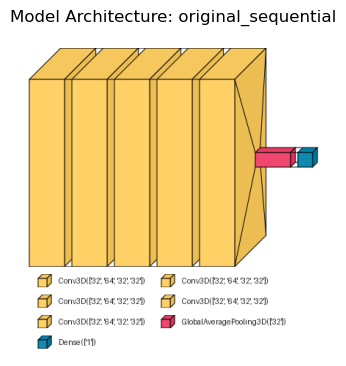

In [15]:
model = buildSequential()
me = ModelEvaluator(model,v_train,v_valid,v_eval)
me.vkPlotArchitecture()

##### Training

In [16]:
me.train(batch_size=4,verbose=verbosity)

Training model: original_sequential

BEGIN: 2025-11-17 10:33:27

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100


I0000 00:00:1763393618.502738  181146 service.cc:152] XLA service 0x74b7cc006120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763393618.502758  181146 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-11-17 10:33:38.584511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763393618.754405  181146 cuda_dnn.cc:529] Loaded cuDNN version 90700


  5/222 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6633 - auc: 0.7606 - loss: 0.6785

I0000 00:00:1763393622.355260  181146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.7527 - auc: 0.6698 - loss: 0.5706 - val_accuracy: 0.7387 - val_auc: 0.3116 - val_loss: 0.5870
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7630 - auc: 0.7206 - loss: 0.5099 - val_accuracy: 0.7387 - val_auc: 0.3930 - val_loss: 0.6594
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7771 - auc: 0.7403 - loss: 0.4931 - val_accuracy: 0.7387 - val_auc: 0.7206 - val_loss: 0.6769
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7823 - auc: 0.7622 - loss: 0.4751 - val_accuracy: 0.7838 - val_auc: 0.8293 - val_loss: 0.4512
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8011 - auc: 0.7909 - loss: 0.4568 - val_accuracy: 0.7477 - val_auc: 0.8656 - val_loss: 0.5078
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8005 - auc: 0.8059 - loss: 0.4454 - val_accuracy: 0.7477 - val_auc: 0.8797 - val_loss: 0.4673
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━

##### Evaluation

Evaluating model: original_sequential

Training Time: 1 minute, 53 seconds, 873136 microseconds
------------------------------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.509091,0.903226,0.651163,31.00000
1,0.946429,0.662500,0.779412,80.00000
accuracy,0.729730,0.729730,0.729730,0.72973
macro avg,0.727760,0.782863,0.715287,111.00000
weighted avg,0.824289,0.729730,0.743594,111.00000


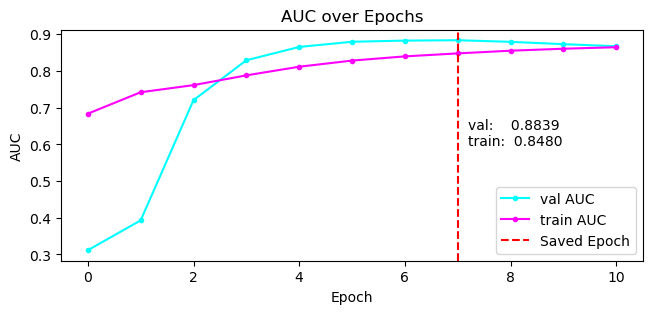

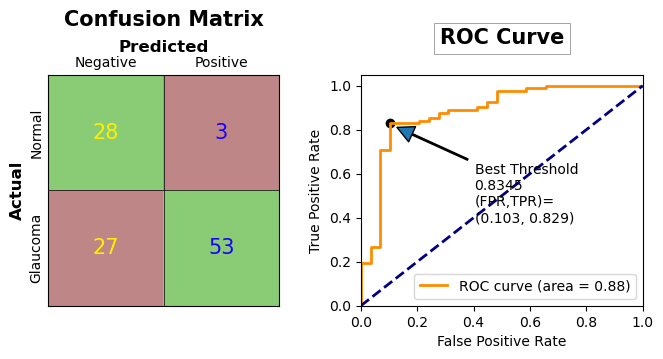

In [17]:
me.evaluate(save_performance_metrics=True)

#### Balanced Dataset

Training model: original_sequential_b

BEGIN: 2025-11-17 10:35:35

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.3988 - auc: 0.3025 - loss: 0.8803 - val_accuracy: 0.5500 - val_auc: 0.5000 - val_loss: 3.1135
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1995 - auc: 0.1425 - loss: 1.0891 - val_accuracy: 0.5500 - val_auc: 0.2716 - val_loss: 0.9329
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1586 - auc: 0.1141 - loss: 0.9110 - val_accuracy: 0.5500 - val_auc: 0.2744 - val_loss: 0.7537
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1596 - auc: 0.1399 - loss: 0.8627 - val_accuracy: 0.5500 - val_auc: 0.2890 - val_loss: 0.7267
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

END: 2025-11-17 10:35:58

 ------------------------------
ELAPSED TIME: 0:00:23.296138

Evaluating model: original_sequential_b

Training Time: 23 seconds, 296137 microseconds
----

,precision,recall,f1-score,support
0,0.555556,0.151515,0.238095,33.000000
1,0.450980,0.851852,0.589744,27.000000
accuracy,0.466667,0.466667,0.466667,0.466667
macro avg,0.503268,0.501684,0.413919,60.000000
weighted avg,0.508497,0.466667,0.396337,60.000000



Performance metrics saved to: models/original_sequential_b/original_sequential_b_metrics.json



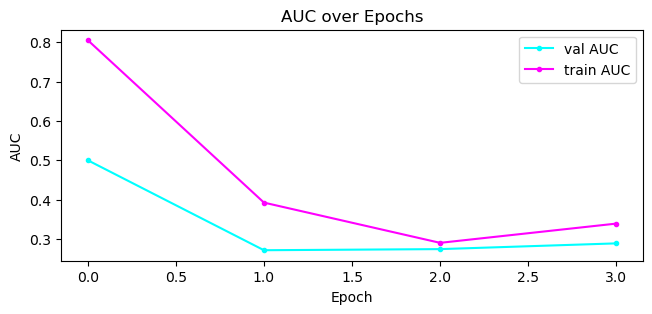

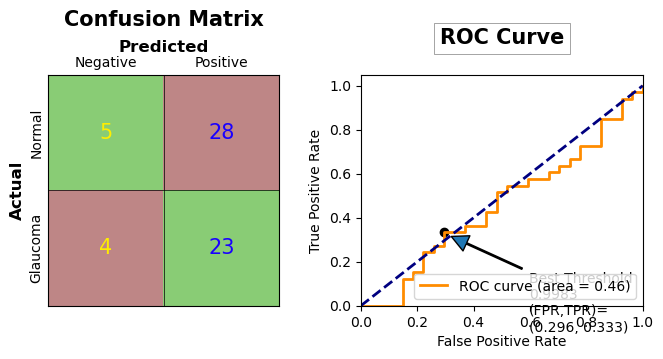

In [18]:
me = ModelEvaluator(model, 
                    model_name = 'original_sequential_b',
                    train_set = vTrainBalanced,
                    validation_set = vValidBalanced,
                    test_set = vEvalBalanced)

me.train_and_evaluate(batch_size=4, 
                      verbose=verbosity, 
                      save_performance_metrics=True)

### 2. ResNetLike 

#### Original Dataset

##### Building & Architecture

/home/etudie/anaconda3/lib/python3.12/site-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


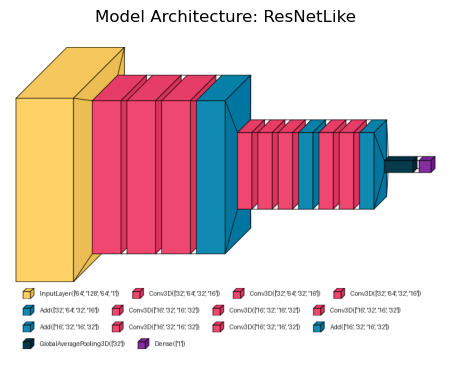

In [19]:
model = buildResNet()
me = ModelEvaluator(model,v_train,v_valid,v_eval)
me.vkPlotArchitecture()

##### Training

In [20]:
me.train(batch_size=4,verbose=verbosity)

Training model: ResNetLike

BEGIN: 2025-11-17 10:36:01

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7670 - auc: 0.7229 - loss: 0.5230 - val_accuracy: 0.7387 - val_auc: 0.5000 - val_loss: 1.2722
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7800 - auc: 0.7440 - loss: 0.4732 - val_accuracy: 0.7387 - val_auc: 0.5000 - val_loss: 1.7681
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8007 - auc: 0.7633 - loss: 0.4577 - val_accuracy: 0.7387 - val_auc: 0.8072 - val_loss: 1.1809
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8035 - auc: 0.7846 - loss: 0.4431 - val_accuracy: 0.7387 - val_auc: 0.8507 - val_loss: 0.7741
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8143 - auc: 0.8041 - loss: 0.4290 - val_accuracy: 0.7387 - val_auc: 0.8680 - val_loss: 0.5997
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8312 - auc: 0

##### Evaluation

Evaluating model: ResNetLike

Training Time: 59 seconds, 450594 microseconds
--------------------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.777778,0.677419,0.724138,31.000000
1,0.880952,0.925000,0.902439,80.000000
accuracy,0.855856,0.855856,0.855856,0.855856
macro avg,0.829365,0.801210,0.813288,111.000000
weighted avg,0.852138,0.855856,0.852643,111.000000


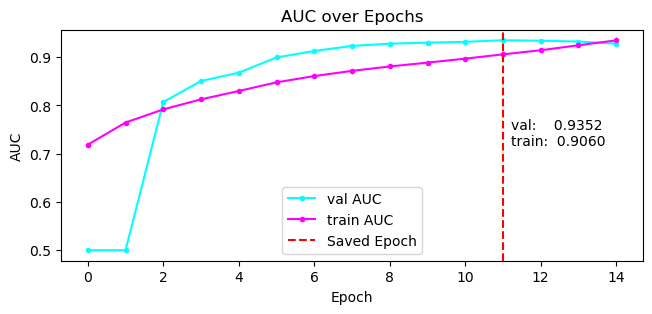

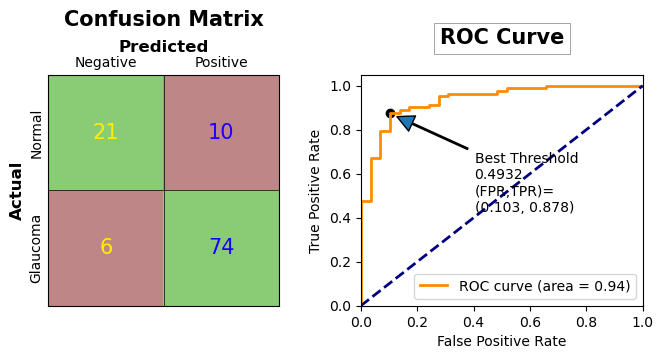

In [21]:
me.evaluate(save_performance_metrics=True)

#### Balanced Dataset

Training model: ResNetLike_b

BEGIN: 2025-11-17 10:37:05

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.3275 - auc: 0.6988 - loss: 1.1233 - val_accuracy: 0.5500 - val_auc: 0.4265 - val_loss: 2.5663
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1879 - auc: 0.1316 - loss: 1.1669 - val_accuracy: 0.5500 - val_auc: 0.4310 - val_loss: 2.7356
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1832 - auc: 0.1033 - loss: 1.2482 - val_accuracy: 0.5500 - val_auc: 0.2907 - val_loss: 1.6148
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1444 - auc: 0.0780 - loss: 1.0456 - val_accuracy: 0.4000 - val_auc: 0.2480 - val_loss: 0.7484
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1914 - auc: 0.1105 - loss: 0.8063 - val_accuracy: 0.5500 - val_auc: 0.2609 - val_loss: 1.1905
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

END: 2025-11-17 10:37:21

 

,precision,recall,f1-score,support
0,0.538462,0.636364,0.583333,33.0
1,0.428571,0.333333,0.375000,27.0
accuracy,0.500000,0.500000,0.500000,0.5
macro avg,0.483516,0.484848,0.479167,60.0
weighted avg,0.489011,0.500000,0.489583,60.0



Performance metrics saved to: models/ResNetLike_b/ResNetLike_b_metrics.json



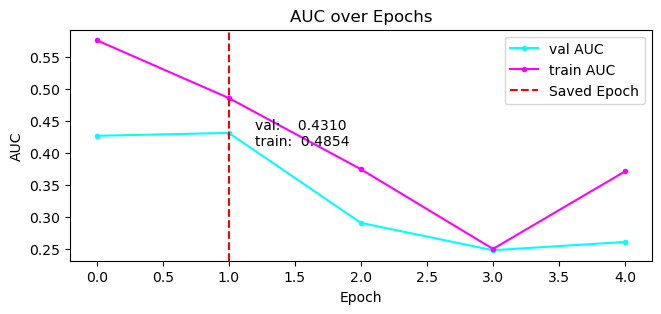

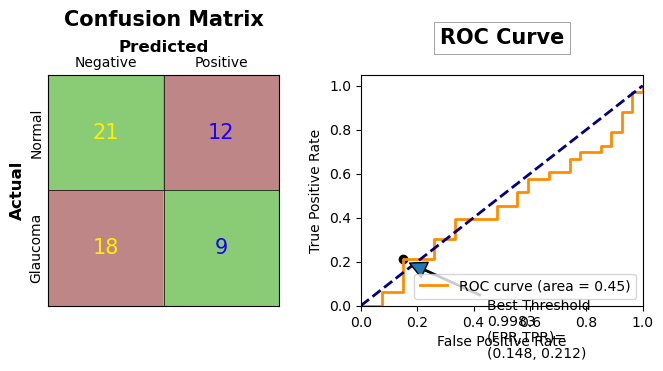

In [22]:
me = ModelEvaluator(model,
                    model_name = "ResNetLike_b",
                    train_set = vTrainBalanced,
                    validation_set = vValidBalanced,
                    test_set = vEvalBalanced)
me.train_and_evaluate(batch_size=4, 
                      verbose=verbosity,
                      save_performance_metrics=True)

### 3. Attention: Squeeze-Excitation & VisualAttention  

#### Original Dataset

##### Building & Architecture

/home/etudie/anaconda3/lib/python3.12/site-packages/visualkeras/layered.py:231: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


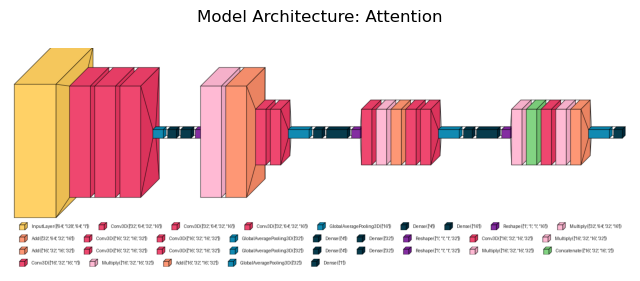

In [23]:
model = buildAttnNN()
me = ModelEvaluator(model,v_train,v_valid,v_eval)
me.vkPlotArchitecture()

##### Training

In [24]:
me.train(batch_size=4,verbose=verbosity)

Training model: Attention

BEGIN: 2025-11-17 10:37:24

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7672 - auc: 0.7310 - loss: 0.5293 - val_accuracy: 0.7387 - val_auc: 0.5050 - val_loss: 0.8516
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7793 - auc: 0.7442 - loss: 0.4761 - val_accuracy: 0.7387 - val_auc: 0.5000 - val_loss: 2.0311
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7886 - auc: 0.7631 - loss: 0.4590 - val_accuracy: 0.7387 - val_auc: 0.8003 - val_loss: 0.9445
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8048 - auc: 0.7929 - loss: 0.4392 - val_accuracy: 0.7477 - val_auc: 0.8577 - val_loss: 0.5195
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8025 - auc: 0.8217 - loss: 0.4217 - val_accuracy: 0.7748 - val_auc: 0.8829 - val_loss: 0.4160
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8040 - auc: 0

##### Evaluation

Evaluating model: Attention

Training Time: 1 minute, 14 seconds, 585403 microseconds
------------------------------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.581395,0.806452,0.675676,31.000000
1,0.911765,0.775000,0.837838,80.000000
accuracy,0.783784,0.783784,0.783784,0.783784
macro avg,0.746580,0.790726,0.756757,111.000000
weighted avg,0.819499,0.783784,0.792549,111.000000


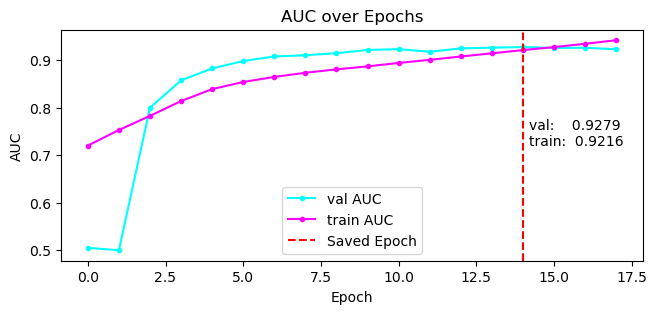

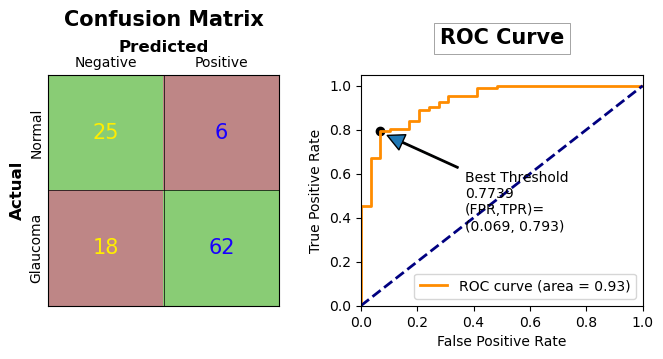

In [25]:
me.evaluate(save_performance_metrics=True)

#### Balanced Dataset

Training model: Attention_b

BEGIN: 2025-11-17 10:38:44

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.1904 - auc: 0.6842 - loss: 1.2625 - val_accuracy: 0.5500 - val_auc: 0.5000 - val_loss: 16.3763
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1579 - auc: 0.1031 - loss: 1.2511 - val_accuracy: 0.4500 - val_auc: 0.7346 - val_loss: 1.0470
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2271 - auc: 0.1443 - loss: 0.9425 - val_accuracy: 0.5500 - val_auc: 0.5421 - val_loss: 1.4300
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1642 - auc: 0.1289 - loss: 1.0095 - val_accuracy: 0.5500 - val_auc: 0.2946 - val_loss: 2.4538
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1286 - auc: 0.0705 - loss: 1.1632 - val_accuracy: 0.5500 - val_auc: 0.5000 - val_loss: 3.7691
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

END: 2025-11-17 10:39:02



,precision,recall,f1-score,support
0,0.807692,0.636364,0.711864,33.000000
1,0.647059,0.814815,0.721311,27.000000
accuracy,0.716667,0.716667,0.716667,0.716667
macro avg,0.727376,0.725589,0.716588,60.000000
weighted avg,0.735407,0.716667,0.716116,60.000000



Performance metrics saved to: models/Attention_b/Attention_b_metrics.json



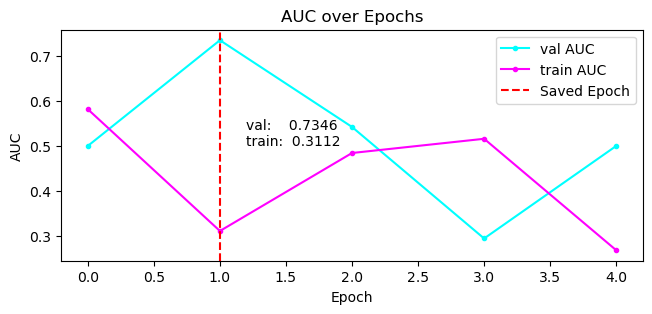

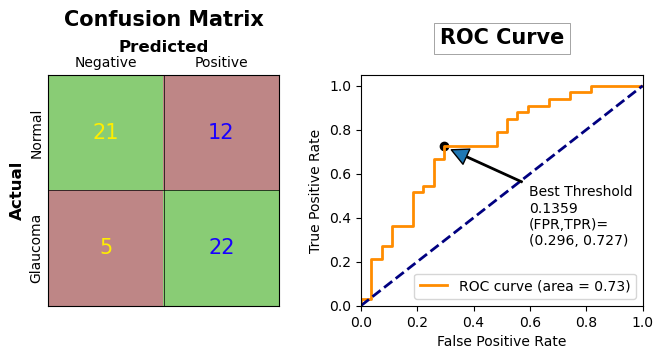

In [26]:
me = ModelEvaluator(model,
                    model_name = "Attention_b",
                    train_set = vTrainBalanced,
                    validation_set = vValidBalanced,
                    test_set = vEvalBalanced)
me.train_and_evaluate(batch_size=4,
                      verbose=verbosity,
                      save_performance_metrics=True)

## Conclusion

### Model Performance & Training Time Comparisons

The training of all models appear to yield suboptimal results when using the balanced dataset.  While the classes are more balanced, it is possible that the associated downsizing of the dataset as a whole may have contributed to this.  It may be of interest in future work to perform additional hyperparameter tuning in case certain tweaks to the model architecture, early stopping callback, compiling steps, and fitting parameters may prevent vanishing or exploding gradients as seen in the AUC over Epochs plots for these training instances.

Nevertheless, the original authors reported favorable metrics using the unbalanced dataset as is, and it would seem that similar results were reproduced here using the same dataset.  Between the original model itself, the ResNetLike model, and the Attention model, there may be a slight increase in performance in Attention and ResNet over Original, although it would be hard to assert whether the performance of Attention or ResNet was better given the final AUC scores were so similar (`0.94` for ResNetLike, `0.93` for Attention).  

When comparing duration of training, the Attention and ResNetLike models were quite similar, at `59 seconds` for ResNetLike and only 15 seconds more for Attention (`1 minute, 14 seconds`).  Meanwhile, the original sequential model notably took longer at around `1 minute, 54 seconds`, while ultimately performing worse with an AUC of `0.88`.

### Model Choice 

For the sake of choosing the best model, it would seem that the ResNetLike model technically performed the best here, with both the highest final AUC score and the shortest training time.  That said, it is important to keep in mind that with smaller datasets, the training results can depend a bit more heavily on initial conditions (e.g., initial weights) which can be inherently random.  As such, it may be that re-running this notebook yields a slightly different set of final AUC scores for each model; perhaps with multiple runs, the Attention model may come out on top for a similar number of times as the ResNetLike model, while the Original model may also come out on top but in rarer instances.